In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import itertools

import os

import xgboost as xgb

from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

In [3]:
colors = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b"
  ]
plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (39.0, 30.0)

## Load data

In [4]:
RAWDATA_FILE_PATH = "rawdata"
details = pd.read_csv("{}/MatchDetail.csv".format(RAWDATA_FILE_PATH))
details.fillna(-1, inplace=True)

overview_train = pd.read_csv("{}/MatchOverviewTraining.csv".format(RAWDATA_FILE_PATH))

overview_test = pd.read_csv("{}/MatchOverviewTest.csv".format(RAWDATA_FILE_PATH))

## One Hot Encode the Hero ids

In [12]:
#one hot the hero ids
heroes = [hero for hero in range(1, 113+1)]

def one_hot_heroes_row(row, team):
    one_hot = [1 if h in team else 0 for h in heroes]
    return pd.Series(one_hot)

one_hot_heroes_team_0_train = overview_train.apply(lambda row: one_hot_heroes_row(row, np.array(row[1:6])),
                                             axis=1, raw=True)
one_hot_heroes_team_0_train.columns = ["team_0_hero_{}".format(h) for h in heroes]

one_hot_heroes_team_1_train = overview_train.apply(lambda row: one_hot_heroes_row(row, np.array(row[6:11])),
                                             axis=1, raw=True)
one_hot_heroes_team_1_train.columns = ["team_1_hero_{}".format(h) for h in heroes]

one_hot_heroes_team_0_test = overview_test.apply(lambda row: one_hot_heroes_row(row, np.array(row[1:6])),
                                             axis=1)

one_hot_heroes_team_0_test.columns = ["team_0_hero_{}".format(h) for h in heroes]

one_hot_heroes_team_1_test = overview_test.apply(lambda row: one_hot_heroes_row(row, np.array(row[6:11])),
                                             axis=1)
one_hot_heroes_team_1_test.columns = ["team_1_hero_{}".format(h) for h in heroes]

## Encode pairings between teammates

Pairings occur sparsely so choose pairings that occur in more than 100 games

Perhaps ensemble xgboost with a model solely based on this.

In [13]:
pairs = [pair for pair in itertools.combinations([i for i in range(1, 113+1)], 2)]

In [22]:
def pairwise_heroes(row, team):
    is_pair = [1 if p[0] in team and p[1] in team else 0 for p in pairs]
    return pd.Series(is_pair)
    

is_pair_team_0_train = overview_train.apply(lambda row: pairwise_heroes(row, np.array(row[1:6])), axis=1)
is_pair_team_0_train.columns = ["team_0_pair_{}".format(str(p)) for p in pairs]

is_pair_team_1_train = overview_train.apply(lambda row: pairwise_heroes(row, np.array(row[6:11])), axis=1)
is_pair_team_1_train.columns = ["team_1_pair_{}".format(str(p)) for p in pairs]

is_pair_team_0_test = overview_test.apply(lambda row: pairwise_heroes(row, np.array(row[1:6])), axis=1)
is_pair_team_0_test.columns = ["team_0_pair_{}".format(str(p)) for p in pairs]

is_pair_team_1_test = overview_test.apply(lambda row: pairwise_heroes(row, np.array(row[6:11])), axis=1)
is_pair_team_1_test.columns = ["team_1_pair_{}".format(str(p)) for p in pairs]

In [15]:
#pairwise across teams (matchups)
#where position does matter, so do pairs permuration

### Pick out the most important pairs

In [23]:
#plot: in all games pair appears in, %win, %loss
t_pairs_train = overview_train.join(is_pair_team_0_train)
t_pairs_train = t_pairs_train.join(is_pair_team_1_train)

pairing_importances_0_train = []
for pair in is_pair_team_0_train.columns:
    games = t_pairs_train[t_pairs_train[pair] == 1]
    if len(games) == 0:
        continue
    win_percent = len(games[games["first_5_won"] == True])*1.0 / len(games)
    pairing_importances_0_train.append((pair, len(games), win_percent, 1 - win_percent))
    
pairing_importances_0_train.sort(key=lambda t:t[2])
    
pairing_importances_1_train = []
for pair in is_pair_team_1_train.columns:
    games = t_pairs_train[t_pairs_train[pair] == 1]
    if len(games) == 0:
        continue
    win_percent = len(games[games["first_5_won"] == True])*1.0 / len(games)
    pairing_importances_1_train.append((pair, len(games), win_percent, 1 - win_percent))
    
pairing_importances_1_train.sort(key=lambda t:t[2])

In [24]:
best_pairings_0_train = is_pair_team_0_train[[t[0] for t in pairing_importances_0_train if t[1] > 100][-10:]]
worst_pairings_0_train = is_pair_team_0_train[[t[0] for t in pairing_importances_0_train if t[1] > 100][:10]]

best_pairings_0_test = is_pair_team_0_test[best_pairings_0_train.columns]
worst_pairings_0_test = is_pair_team_0_test[worst_pairings_0_train.columns]

In [25]:
best_pairings_1_train = is_pair_team_1_train[[t[0] for t in pairing_importances_1_train if t[1] > 100][-10:]]
worst_pairings_1_train = is_pair_team_1_train[[t[0] for t in pairing_importances_1_train if t[1] > 100][:10]]

best_pairings_1_test = is_pair_team_1_test[best_pairings_1_train.columns]
worst_pairings_1_test = is_pair_team_1_test[worst_pairings_1_train.columns]

## Encoding pairwise between enemies

In [21]:
pairs = [pair for pair in itertools.combinations([i for i in range(1, 113+1)], 2)]
enemy_pairs = [(i, j) for i in range(1, 113+1) for j in range(1, 113+1)]

In [26]:
def pairwise_enemies(row, team0, team1):
    is_enemy = [1 if p[0] in team0 and p[1] in team1 else 0 for p in enemy_pairs]
    return pd.Series(is_enemy)
    

is_enemy_train = overview_train.apply(lambda row: pairwise_enemies(row, 
                                                np.array(row[1:6]), np.array(row[6:11])), axis=1)
is_enemy_train.columns = ["enemy_pair_{}".format(str(p)) for p in enemy_pairs]

is_enemy_test = overview_test.apply(lambda row: pairwise_enemies(row, 
                                                np.array(row[1:6]), np.array(row[6:11])), axis=1)
is_enemy_test.columns = ["enemy_pair_{}".format(str(p)) for p in enemy_pairs]

In [27]:
t_enemies_train = overview_train.join(is_enemy_train)

enemy_importances_train = []
for pair in is_enemy_train.columns:
    games = t_enemies_train[t_enemies_train[pair] == 1]
    if len(games) == 0:
        continue
    win_percent = len(games[games["first_5_won"] == True])*1.0 / len(games)
    enemy_importances_train.append((pair, len(games), win_percent, 1 - win_percent))
    
enemy_importances_train.sort(key=lambda t:t[2])

In [28]:
best_enemies_train = is_enemy_train[[t[0] for t in enemy_importances_train if t[1] > 100][-10:]]
worst_enemies_train = is_enemy_train[[t[0] for t in enemy_importances_train if t[1] > 100][:10]]

best_enemies_test = is_enemy_test[best_enemies_train.columns]
worst_enemies_test = is_enemy_test[worst_enemies_train.columns]

# Details Feature Engineering
### For each team:
-Team experience (intervals)

-Team gold (intervals)

-Team experience (cummulative)

-Team gold (cummulative)

### Not specific to one team
-Team experience difference (intervals)

-Team gold difference (intervals)

-Team experience difference (cummulative)

-Team gold difference (cummulative)

In [7]:
#team gold earned intervals
details_d = {} #match_id/team/list of rows
details_intervals_d = {}
for index, row in details.iterrows():
    match_id = int(row[0])
    player_id = int(row[2])
    rest_row = row[3:]
    if match_id not in details_d:
        teams = {0: [0 for _ in range(5)], 1: [0 for _ in range(5)]}
        teams_interval = {0: [0 for _ in range(5)], 1: [0 for _ in range(5)]}
        details_d[match_id] = teams
        details_intervals_d[match_id] = teams_interval
    else:
        teams = details_d[match_id]
        teams_interval = details_intervals_d[match_id]
    team_id = 0
    if player_id >= 5:
        team_id = 1
        player_id -= 5
    teams[team_id][player_id] = rest_row
    teams_interval[team_id][player_id] = pd.Series([rest_row[i+1] - rest_row[i] for i in range(9)] + \
                                    [rest_row[i+1] - rest_row[i] for i in range(10, 19)])

In [46]:
team_detail_column_names = []
l = team_detail_column_names
l.extend(["game_length"])
l.extend(["e{}->{}_team0_interval".format(i*5, (i+1)*5) for i in range(9)])
l.extend(["g{}->{}_team0_interval".format(i*5, (i+1)*5) for i in range(9)])
l.extend(["e{}->{}_team1_interval".format(i*5, (i+1)*5) for i in range(9)])
l.extend(["g{}->{}_team1_interval".format(i*5, (i+1)*5) for i in range(9)])
l.extend(["e{}_team0_cumsum".format(i*5) for i in range(10)])
l.extend(["g{}_team0_cumsum".format(i*5) for i in range(10)])
l.extend(["e_team0_cumsum_var"])
l.extend(["g_team0_cumsum_var"])
l.extend(["e{}_team1_cumsum".format(i*5) for i in range(10)])
l.extend(["g{}_team1_cumsum".format(i*5) for i in range(10)])
l.extend(["e_team1_cumsum_var"])
l.extend(["g_team1_cumsum_var"])

l.extend(["e{}_team_cumsum_percent".format(i*5) for i in range(9)])
l.extend(["g{}_team_cumsum_percent".format(i*5) for i in range(9)])

l.extend(["e{}->{}_team_interval_percent".format(i*5, (i+1)*5) for i in range(9)])
l.extend(["g{}->{}_team_interval_percent".format(i*5, (i+1)*5) for i in range(9)])


l.extend(["e{}->{}_team_interval_diff".format(i*5, (i+1)*5) for i in range(9)])
l.extend(["g{}->{}_team_interval_diff".format(i*5, (i+1)*5) for i in range(9)])
l.extend(["e{}_team_cumsum_diff".format(i*5) for i in range(10)])
l.extend(["g{}_team_cumsum_diff".format(i*5) for i in range(10)])

#add percent differences between cumsums "how much of the total gold does this team have"

def team_details_by_row(row):
    match_id = int(row[0])
    if match_id not in details_intervals_d:
        return None
    game_length = np.where(np.array(details_intervals_d[match_id][0][0]) == 0)[0]
    if len(game_length) == 0:
        game_length = 9
    else:
        game_length = game_length[0]
    t0_intervals = sum(details_intervals_d[match_id][0])
    t1_intervals = sum(details_intervals_d[match_id][1])
    t0_intervals[t0_intervals < 0] = 0
    t1_intervals[t1_intervals < 0] = 0
    t0_cumsum = sum(details_d[match_id][0]) #set the rest of each cumsum/interval to be last non-zero element
    t0_cumsum_e_var = np.std(t0_cumsum[:9])
    t0_cumsum_g_var = np.std(t0_cumsum[9:])
    t1_cumsum = sum(details_d[match_id][1])
    t1_cumsum_e_var = np.std(t1_cumsum[:9])
    t1_cumsum_g_var = np.std(t1_cumsum[9:])
    
    #calculate percentage of total gold by team 0
    #calculate percentage of total exp by team 1
    cumsum_e_total = t0_cumsum[1:9] + t1_cumsum[1:9]
    cumsum_e_percent = t0_cumsum[1:9] / cumsum_e_total
    cumsum_e_percent[np.isnan(cumsum_e_percent)] = -1
    
    cumsum_g_total = t0_cumsum[10:] + t1_cumsum[10:]
    cumsum_g_percent = t0_cumsum[10:] / cumsum_g_total
    cumsum_g_percent[np.isnan(cumsum_g_percent)] = -1
    
    
    interval_e_total = t0_intervals[:9] + t1_intervals[:9]
    interval_e_percent = t0_intervals[:9] / interval_e_total
    interval_e_percent[np.isnan(interval_e_percent)] = -1
    
    interval_g_total = t0_intervals[9:] + t1_intervals[9:]
    interval_g_percent = t0_intervals[9:] / interval_g_total
    interval_g_percent[np.isnan(interval_g_percent)] = -1
    
    
    #ratio intervals
    #ratio cumsums
    
    #how has interval changed interval_k / interval_{k-1}
    
    #calculate variance of each team's players
    #1 carry not good, all fed = good
    t_diff_intervals = t1_intervals - t0_intervals 
    t_diff_cumsum = t1_cumsum - t0_cumsum
#     print [type(l) for l in [t0_intervals, t1_intervals, t0_cumsum, t1_cumsum, t_diff_intervals, t_diff_cumsum]]
    new_series = pd.concat([pd.Series(game_length), t0_intervals, t1_intervals, 
                            t0_cumsum, pd.Series(t0_cumsum_e_var), pd.Series(t0_cumsum_g_var),
                            t1_cumsum, pd.Series(t1_cumsum_e_var), pd.Series(t1_cumsum_g_var),
                            cumsum_e_percent, cumsum_g_percent,
                            interval_e_percent, interval_g_percent,
                            t_diff_intervals, t_diff_cumsum])
    new_series.columns = team_detail_column_names
    return new_series
    

team_details_train = overview_train.apply(team_details_by_row, axis=1)
team_details_train.columns = team_detail_column_names

team_details_test = overview_test.apply(team_details_by_row, axis=1)

team_details_test.columns = team_detail_column_names

In [24]:
team_details_train["e40_team1_cumsum"][:20]

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
Name: e40_team1_cumsum, dtype: float64

In [25]:
team_details_train["e40->45_team1_interval"][:20]

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
Name: e40->45_team1_interval, dtype: float64

In [22]:
team_details_train["e40_team_cumsum_percent"][:20]

0     0.998806
1     0.007305
2     0.994090
3     0.996066
4     0.998319
5     0.992260
6     0.996673
7     0.998378
8     0.013605
9     0.997727
10    0.968652
11    1.000000
12    0.995434
13    0.500000
14    0.994350
15    0.976303
16    0.993523
17    0.718961
18    0.500000
19    0.954545
Name: e40_team_cumsum_percent, dtype: float64

## Store all of the features separately

Under the assumption that rows are statically positioned since these feature files will not have match_id columns

I could set the indicies to match_id

In [65]:
one_hot_train = one_hot_heroes_team_0_train.join(one_hot_heroes_team_1_train)
one_hot_test = one_hot_heroes_team_0_test.join(one_hot_heroes_team_1_test)

one_hot_train.to_csv("features/one_hot_train", index=False)

one_hot_test.to_csv("features/one_hot_test", index=False)

In [66]:
team_details_train.to_csv("features/details_train", index=False)

team_details_test.to_csv("features/details_test", index=False)

In [67]:
pairings_train = best_pairings_0_train.join(best_pairings_1_train)
pairings_train = pairings_train.join(worst_pairings_0_train)
pairings_train = pairings_train.join(worst_pairings_1_train)

pairings_test = best_pairings_0_test.join(best_pairings_1_test)
pairings_test = pairings_test.join(worst_pairings_0_test)
pairings_test = pairings_test.join(worst_pairings_1_test)

pairings_train.to_csv("features/pairings_train", index=False)

pairings_test.to_csv("features/pairings_test", index=False)

In [68]:
enemies_train = best_enemies_train.join(worst_enemies_train)

enemies_test = best_enemies_test.join(worst_enemies_test)

enemies_train.to_csv("features/enemies_train", index=False)

enemies_test.to_csv("features/enemies_test", index=False)

## Load features

In [9]:
one_hot_train = pd.read_csv("features/one_hot_train")

one_hot_test = pd.read_csv("features/one_hot_test")

In [10]:
team_details_train = pd.read_csv("features/details_train")

team_details_test = pd.read_csv("features/details_test")

#### Remove certain features from details feature set

In [8]:
exclude_cols = []
exclude_cols.extend(["e{}->{}_team_interval_percent".format(i*5, (i+1)*5) for i in range(9)])
exclude_cols.extend(["g{}->{}_team_interval_percent".format(i*5, (i+1)*5) for i in range(9)])
# exclude_cols.extend(["e{}_team_cumsum_percent".format(i*5) for i in range(9)])
# excluse_cols.extend(["g{}_team_cumsum_percent".format(i*5) for i in range(9)])
keep_cols = [col for col in team_details_train if col not in exclude_cols]

team_details_train = team_details_train[keep_cols]
team_details_test = team_details_test[keep_cols]

NameError: name 'exclude_col' is not defined

In [11]:
pairings_train = pd.read_csv("features/pairings_train")

pairings_test = pd.read_csv("features/pairings_test")

In [12]:
enemies_train = pd.read_csv("features/enemies_train")

enemies_test = pd.read_csv("features/enemies_test")

## Plot features

In [42]:
def win_percent(df, feature_col): #for binary features
    games_with_feature_true = df["first_5_won"][feature_col == 1]
    p = np.mean(games_with_feature_true)
    return p, 1-p

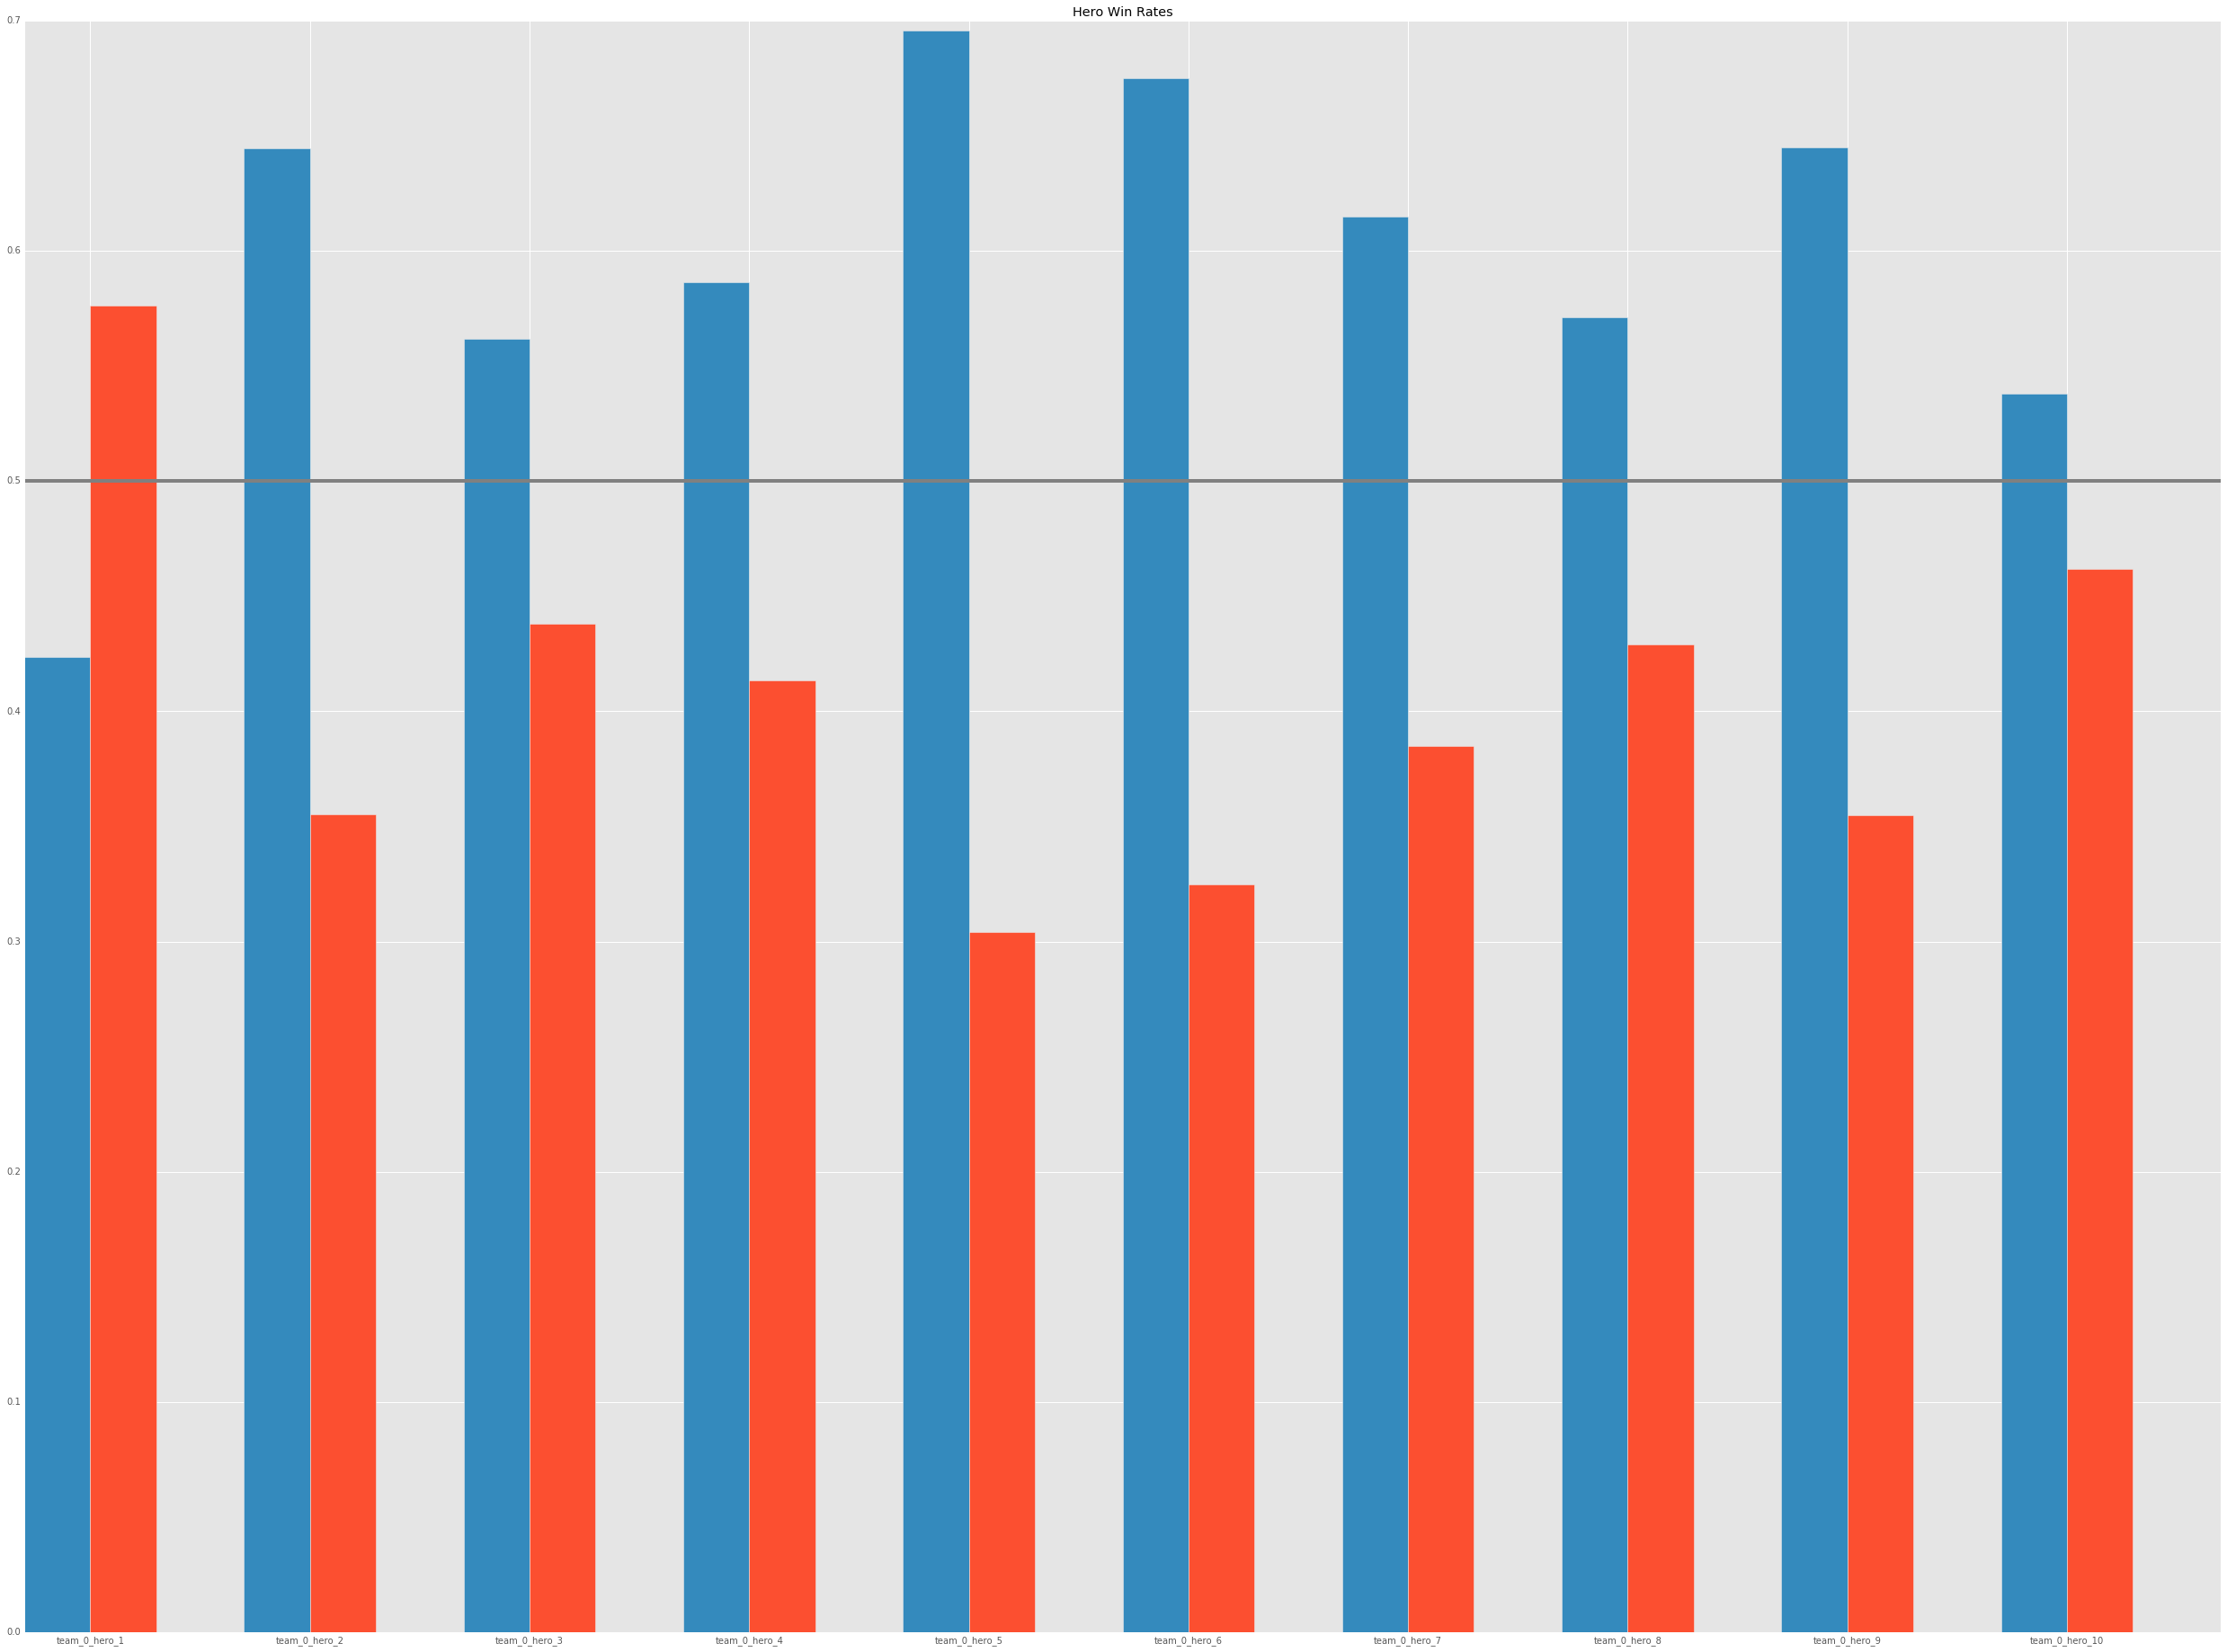

In [56]:
# overview_train["first_5_won"][]

# p, p0 = win_percent(overview_train, one_hot_train["team_1_hero_1"])
#only look at cols where there is more than 100 games
look_at_cols = one_hot_train.columns[:10]
l = [win_percent(overview_train, one_hot_train[col]) for col in look_at_cols]

p, p0 = zip(*l)

fig, ax = plt.subplots()

x = np.arange(len(p))
width = 0.3

ax.plot([0.5 for _ in range(len(l)+1)], color="grey")

ax.bar(x, p, width)
ax.bar(x+width, p0, width, color="#fc4f30")

ax.set_xticks(x+width)
ax.set_xticklabels(look_at_cols)
plt.title("Hero Win Rates")
plt.show()

## Join the features together and store them as well

In [73]:
#join all of them at the end

#one hot of heroes
t_base_train = overview_train.join(one_hot_train)

t_base_test = overview_test.join(one_hot_test)

In [74]:
t_base_train.to_csv("transformed_data/one_hot_heroes_train", index=False)
t_base_test.to_csv("transformed_data/one_hot_heroes_test", index=False)

In [57]:
t_base_train = pd.read_csv("transformed_data/one_hot_heroes_train")
t_base_test = pd.read_csv("transformed_data/one_hot_heroes_test")

In [58]:
t_details_train = t_base_train.join(team_details_train)
t_details_train.to_csv("transformed_data/one_hot_heroes_details_train", index=False)

t_details_test = t_base_test.join(team_details_test)
t_details_test.to_csv("transformed_data/one_hot_heroes_details_test", index=False)

In [59]:
t_details_pairings_train = t_details_train.join(pairings_train)

t_details_pairings_test = t_details_test.join(pairings_test)

In [60]:
t_details_pairings_train.to_csv("transformed_data/one_hot_heroes_details_pairs_train", index=False)

t_details_pairings_test.to_csv("transformed_data/one_hot_heroes_details_pairs_test", index=False)

In [61]:
t_pairings_train = t_base_train.join(pairings_train)

t_pairings_test = t_base_test.join(pairings_test)

In [62]:
t_pairings_train.to_csv("transformed_data/pairs_train", index=False)

t_pairings_test.to_csv("transformed_data/pairs_test", index=False)

In [63]:
t_pairings_enemies_train = t_pairings_train.join(enemies_train)

t_pairings_enemies_test = t_pairings_test.join(enemies_test)

In [64]:
t_pairings_enemies_train.to_csv("transformed_data/pairs_enemies_train", index=False)

t_pairings_enemies_test.to_csv("transformed_data/pairs_enemies_test", index=False)

In [65]:
t_details_pairings_enemies_train = t_details_pairings_train.join(enemies_train)

t_details_pairings_enemies_test = t_details_pairings_test.join(enemies_test)

In [66]:
t_details_pairings_enemies_train.to_csv("transformed_data/one_hot_heroes_details_pairs_enemies_train", index=False)

t_details_pairings_enemies_test.to_csv("transformed_data/one_hot_heroes_details_pairs_enemies_test", index=False)

# Get training data (X, y)

In [16]:
def get_xgb_model():
    return xgb.XGBClassifier(
        learning_rate=0.05,
        n_estimators=1000,
        max_depth=3,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.9,
        reg_alpha=1,
        nthread=4,
        scale_pos_weight=1,
        seed=27
    )

## Keeping track of each iteration of Grid Search's CV score
(
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=3
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_alpha=1,
    nthread=4,
    scale_pos_weight=1,
    seed=27
)[ 0.99677766  0.9924812   0.96562836  0.98496241  0.98600646]
0.98517121652354778


[mean: 0.98668, std: 0.00685, params: {'max_depth': 2, 'min_child_weight': 1}, mean: 0.98517, std: 0.00959, params: {'max_depth': 3, 'min_child_weight': 1}, mean: 0.98517, std: 0.01068, params: {'max_depth': 4, 'min_child_weight': 1}]
[mean: 0.98668, std: 0.00685, params: {'max_depth': 2, 'min_child_weight': 1}, mean: 0.98474, std: 0.00868, params: {'max_depth': 2, 'min_child_weight': 2}, mean: 0.98517, std: 0.00959, params: {'max_depth': 3, 'min_child_weight': 1}, mean: 0.98517, std: 0.01036, params: {'max_depth': 3, 'min_child_weight': 2}]
{'max_depth': 2, 'min_child_weight': 1}
(
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=2
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_alpha=1,
    nthread=4,
    scale_pos_weight=1,
    seed=27
)
0.98667526327100796

## CV Score

In [265]:
xgb_model_cv = get_xgb_model()
cv_scores = cross_val_score(xgb_model_cv, t2_train_X1, t2_train_Y1, cv=5)
print cv_scores
np.mean(cv_scores)

[ 0.99677766  0.9924812   0.96562836  0.98496241  0.98600646]


0.98517121652354778

## Grid Search iteratively

In [269]:
params_grid = {
        'max_depth': range(2, 4, 1),
        'min_child_weight': range(1, 3, 1)
    }
g_search = GridSearchCV(estimator=get_xgb_model(),
                            param_grid=params_grid,
                            iid=True,
                            cv=5)
g_search.fit(t2_train_X1, t2_train_Y1)
print g_search.grid_scores_
print g_search.best_params_
g_search.best_score_

[mean: 0.98668, std: 0.00685, params: {'max_depth': 2, 'min_child_weight': 1}, mean: 0.98474, std: 0.00868, params: {'max_depth': 2, 'min_child_weight': 2}, mean: 0.98517, std: 0.00959, params: {'max_depth': 3, 'min_child_weight': 1}, mean: 0.98517, std: 0.01036, params: {'max_depth': 3, 'min_child_weight': 2}]
{'max_depth': 2, 'min_child_weight': 1}


0.98667526327100796

In [262]:
g_search.best_params_

{'max_depth': 2, 'min_child_weight': 1}

In [270]:
params_grid = {
        'gamma':[i/10.0 for i in range(0,5)]
    }
g_search = GridSearchCV(estimator=get_xgb_model(),
                            param_grid=params_grid,
                            iid=True,
                            cv=5)
g_search.fit(t2_train_X1, t2_train_Y1)
print g_search.grid_scores_
print g_search.best_params_
g_search.best_score_

[mean: 0.98517, std: 0.01068, params: {'gamma': 0.0}, mean: 0.98517, std: 0.01049, params: {'gamma': 0.1}, mean: 0.98517, std: 0.00988, params: {'gamma': 0.2}, mean: 0.98496, std: 0.01135, params: {'gamma': 0.3}, mean: 0.98517, std: 0.01152, params: {'gamma': 0.4}]
{'gamma': 0.0}


0.98517085751128308

In [ ]:
params_grid = {
        'subsample':[i/10.0 for i in range(6,10)],
        'colsample_bytree':[i/10.0 for i in range(6,10)]
    }
g_search = GridSearchCV(estimator=get_xgb_model(),
                            param_grid=params_grid,
                            iid=True,
                            cv=5)
g_search.fit(t2_train_X1, t2_train_Y1)
print g_search.grid_scores_
print g_search.best_params_
g_search.best_score_

In [257]:
params_grid = {
        'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
    }
g_search = GridSearchCV(estimator=get_xgb_model(),
                            param_grid=params_grid,
                            iid=True,
                            cv=5)
g_search.fit(t2_train_X1, t2_train_Y1)
print g_search.grid_scores_
print g_search.best_params_
g_search.best_score_

[ 0.99301826  0.97851772  0.98871574  0.98334229  0.9844086 ]


0.98560052365602746

## Bagging

## Main model

In [204]:
t_sub_train = pd.read_csv("transformed_data/one_hot_heroes_details_pairs_train")
t_sub_train = t_sub_train.dropna()
t_sub_train = t_sub_train[(t_sub_train.isnull().any(axis=1)) == False]
t_sub_train_X = t_sub_train[t_sub_train.columns[12:]]
t_sub_train_Y = t_sub_train[t_sub_train.columns[11]]

In [205]:
xgb_model_cv = get_xgb_model()
cv_scores = cross_val_score(xgb_model_cv,t_sub_train_X, t_sub_train_Y, cv=3)
print cv_scores
np.mean(cv_scores)

[ 0.98710509  0.9858156   0.98355899]


0.98549323017408119

### Without percentage

In [7]:
t_sub_train2 = pd.read_csv("transformed_data/one_hot_heroes_details_pairs_enemies_train")
t_sub_train2 = t_sub_train2.dropna()
t_sub_train2 = t_sub_train2[(t_sub_train2.isnull().any(axis=1)) == False]
t_sub_train2_X = t_sub_train2[t_sub_train2.columns[12:]]
t_sub_train2_Y = t_sub_train2[t_sub_train2.columns[11]]

In [207]:
xgb_model_cv = get_xgb_model()
cv_scores = cross_val_score(xgb_model_cv,t_sub_train2_X, t_sub_train2_Y, cv=3)
print cv_scores
np.mean(cv_scores)

[ 0.98613798  0.98646035  0.98420374]


0.9856006877283473

### With percentage

In [8]:
t_sub_train2 = pd.read_csv("transformed_data/one_hot_heroes_details_pairs_enemies_train")
t_sub_train2 = t_sub_train2.dropna()
t_sub_train2 = t_sub_train2[(t_sub_train2.isnull().any(axis=1)) == False]
t_sub_train2_X = t_sub_train2[t_sub_train2.columns[12:]]
t_sub_train2_Y = t_sub_train2[t_sub_train2.columns[11]]

In [45]:
xgb_model_cv = get_xgb_model()
cv_scores = cross_val_score(xgb_model_cv,t_sub_train2_X, t_sub_train2_Y, cv=3)
print cv_scores
np.mean(cv_scores)

[ 0.98710509  0.98742747  0.98517086]


0.98656780571674185

### With interval percentage

In [6]:
t_sub_train2 = pd.read_csv("transformed_data/one_hot_heroes_details_pairs_enemies_train")
t_sub_train2 = t_sub_train2.dropna()
t_sub_train2 = t_sub_train2[(t_sub_train2.isnull().any(axis=1)) == False]
t_sub_train2_X = t_sub_train2[t_sub_train2.columns[12:]]
t_sub_train2_Y = t_sub_train2[t_sub_train2.columns[11]]

In [69]:
xgb_model_cv = get_xgb_model()
cv_scores = cross_val_score(xgb_model_cv,t_sub_train2_X, t_sub_train2_Y, cv=10)
print cv_scores
np.mean(cv_scores)

[ 0.99570354  0.98925886  0.97529538  0.98388829  0.98925886  0.99033298
  0.97744361  0.99032258  0.98387097  0.98708288]


0.98624579584511629

In [12]:
xgb_model_submission = xgb.XGBClassifier(
        learning_rate=0.05,
        n_estimators=800,
        max_depth=3,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.9,
        reg_alpha=1,
        nthread=4,
        scale_pos_weight=1,
        seed=27
    )

xgb_model_submission.fit(t_sub_train2_X, t_sub_train2_Y, verbose=True)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=800, nthread=4,
       objective='binary:logistic', reg_alpha=1, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

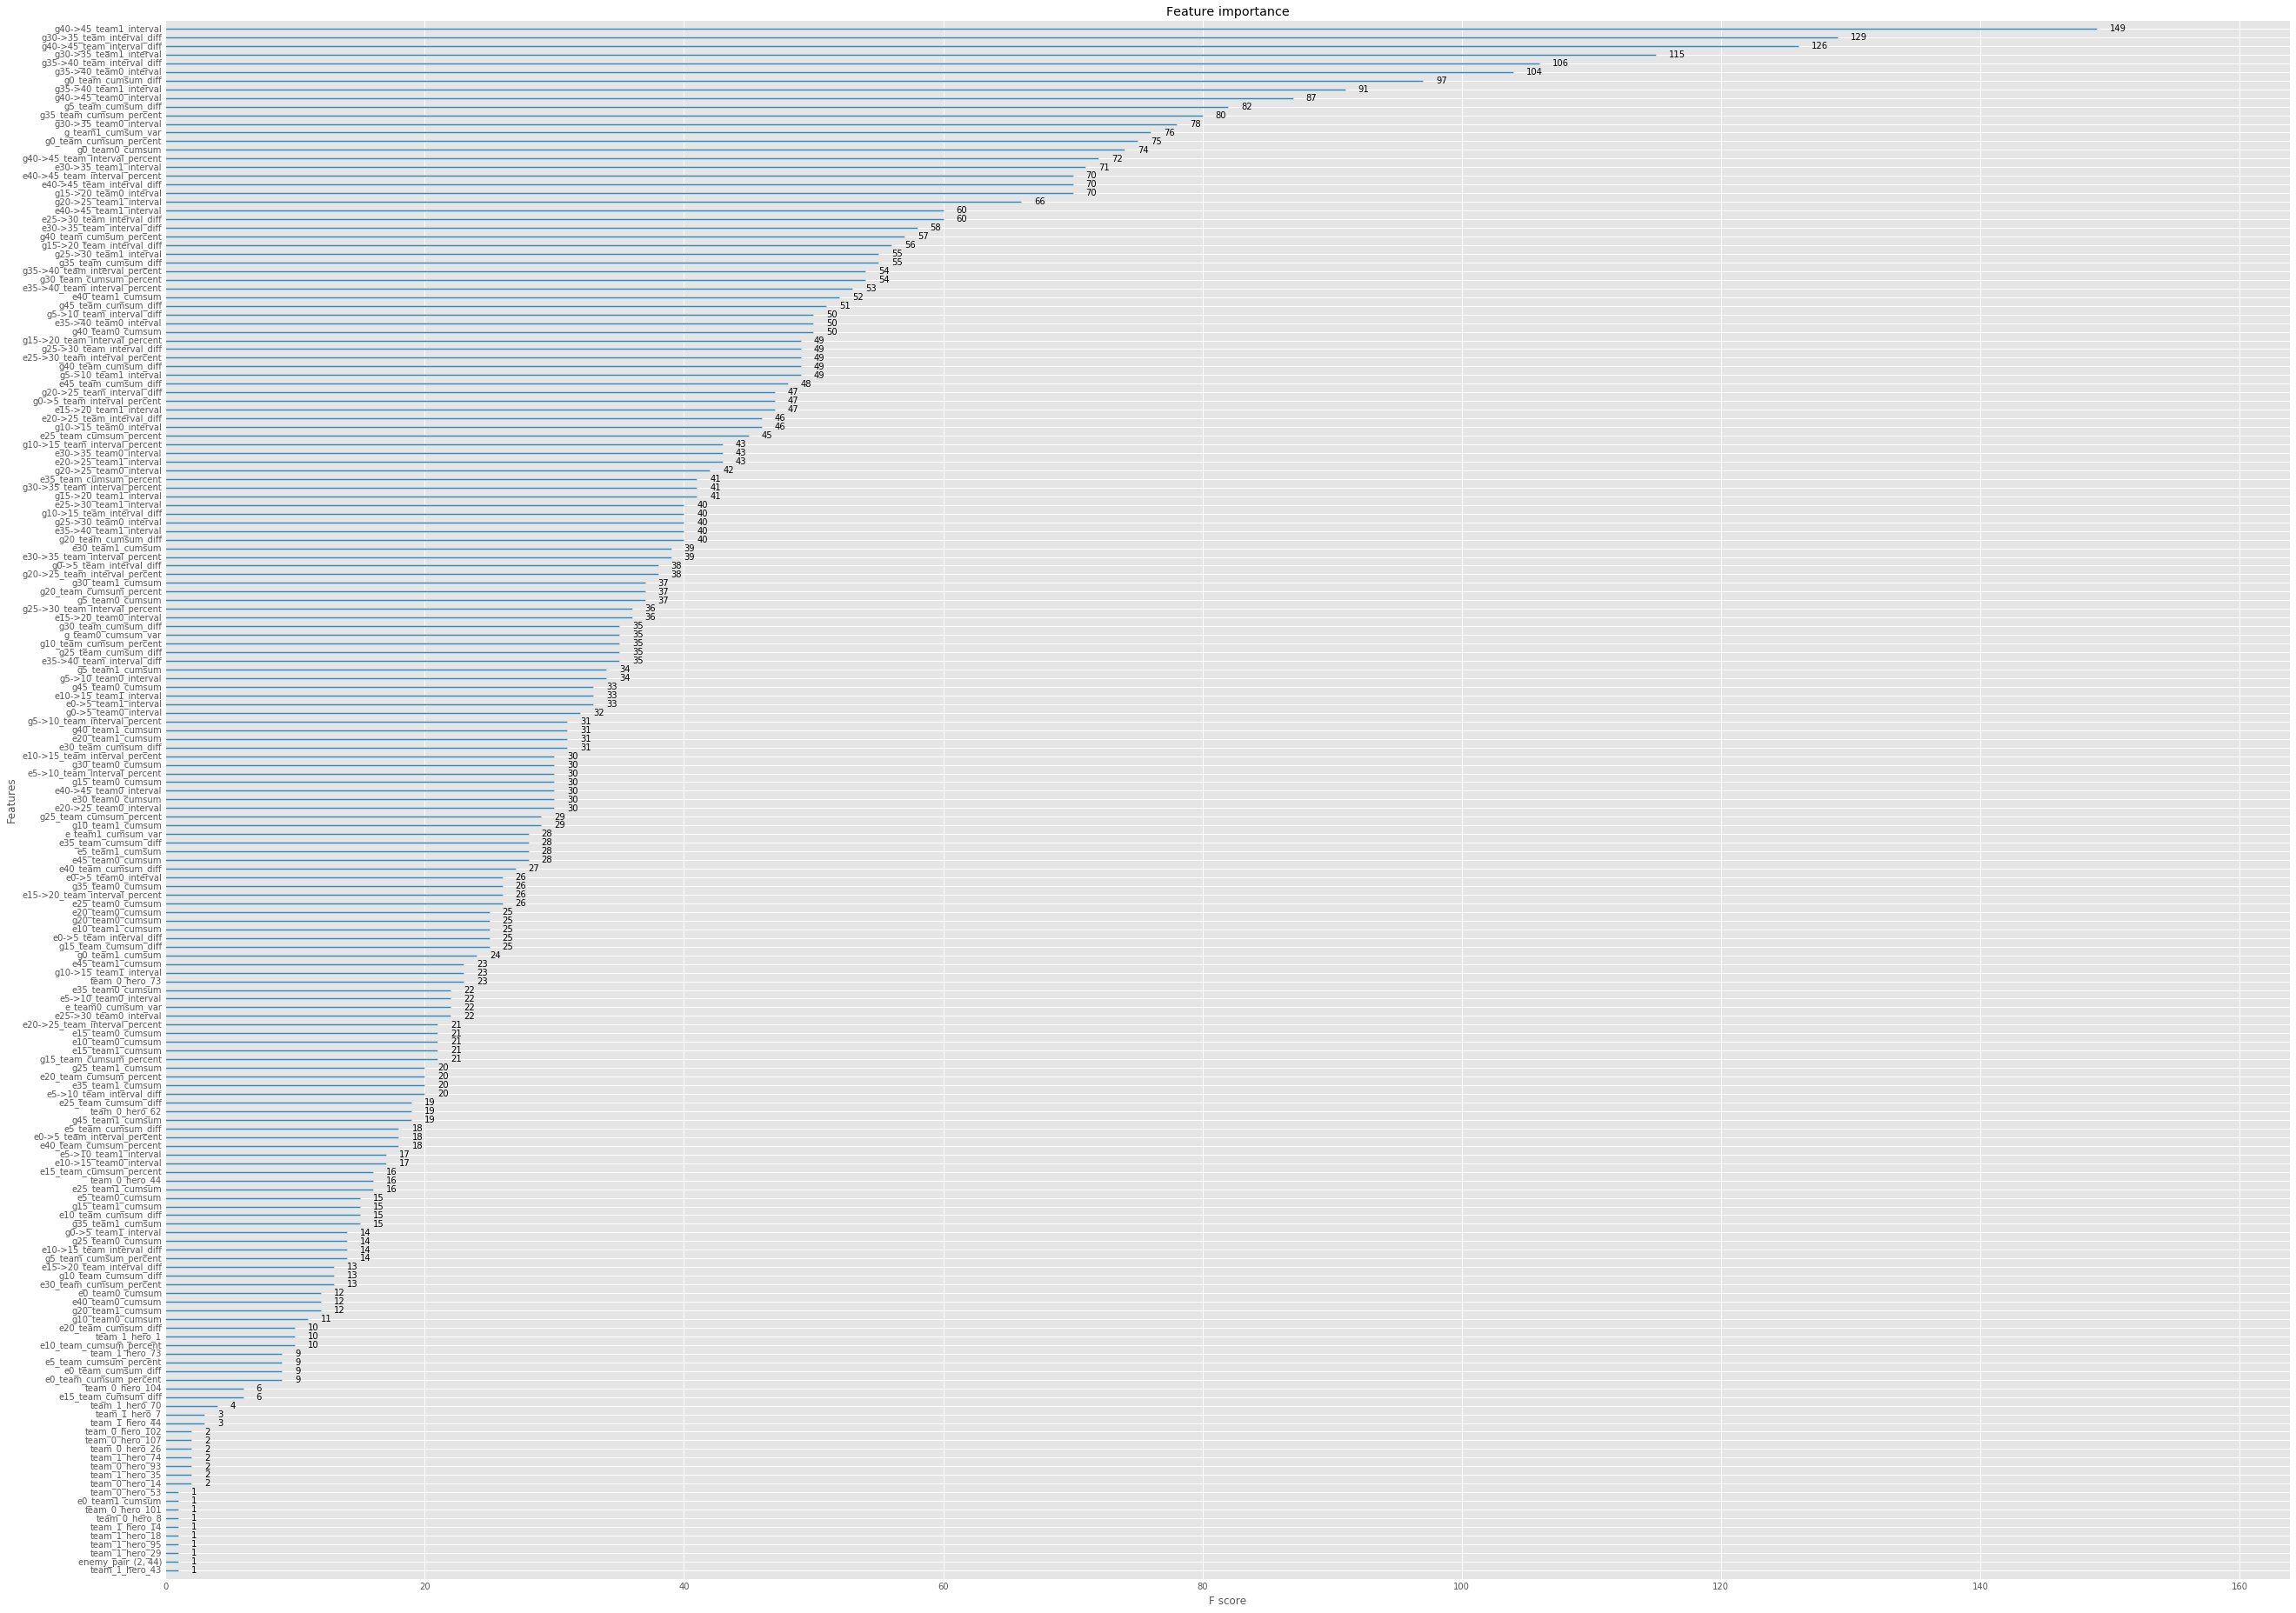

In [71]:
xgb.plot_importance(xgb_model_submission)

## Other models

### Model purely based on team composition alone

In [9]:
def get_xgb_model_team_comp():
    return xgb.XGBClassifier(
        learning_rate=0.05,
        n_estimators=1000,
        max_depth=3,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.9,
        reg_alpha=1,
        nthread=4,
        scale_pos_weight=1,
        seed=27
    )

In [10]:
t_team_comp_train = pd.read_csv("transformed_data/pairs_enemies_train")
t_team_comp_train_X = t_team_comp_train[t_team_comp_train.columns[12:]]
t_team_comp_train_Y = t_team_comp_train[t_team_comp_train.columns[11]]

In [11]:
xgb_team_comp = get_xgb_model_team_comp()
xgb_team_comp.fit(t_team_comp_train_X, t_team_comp_train_Y, verbose=True)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=4,
       objective='binary:logistic', reg_alpha=1, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

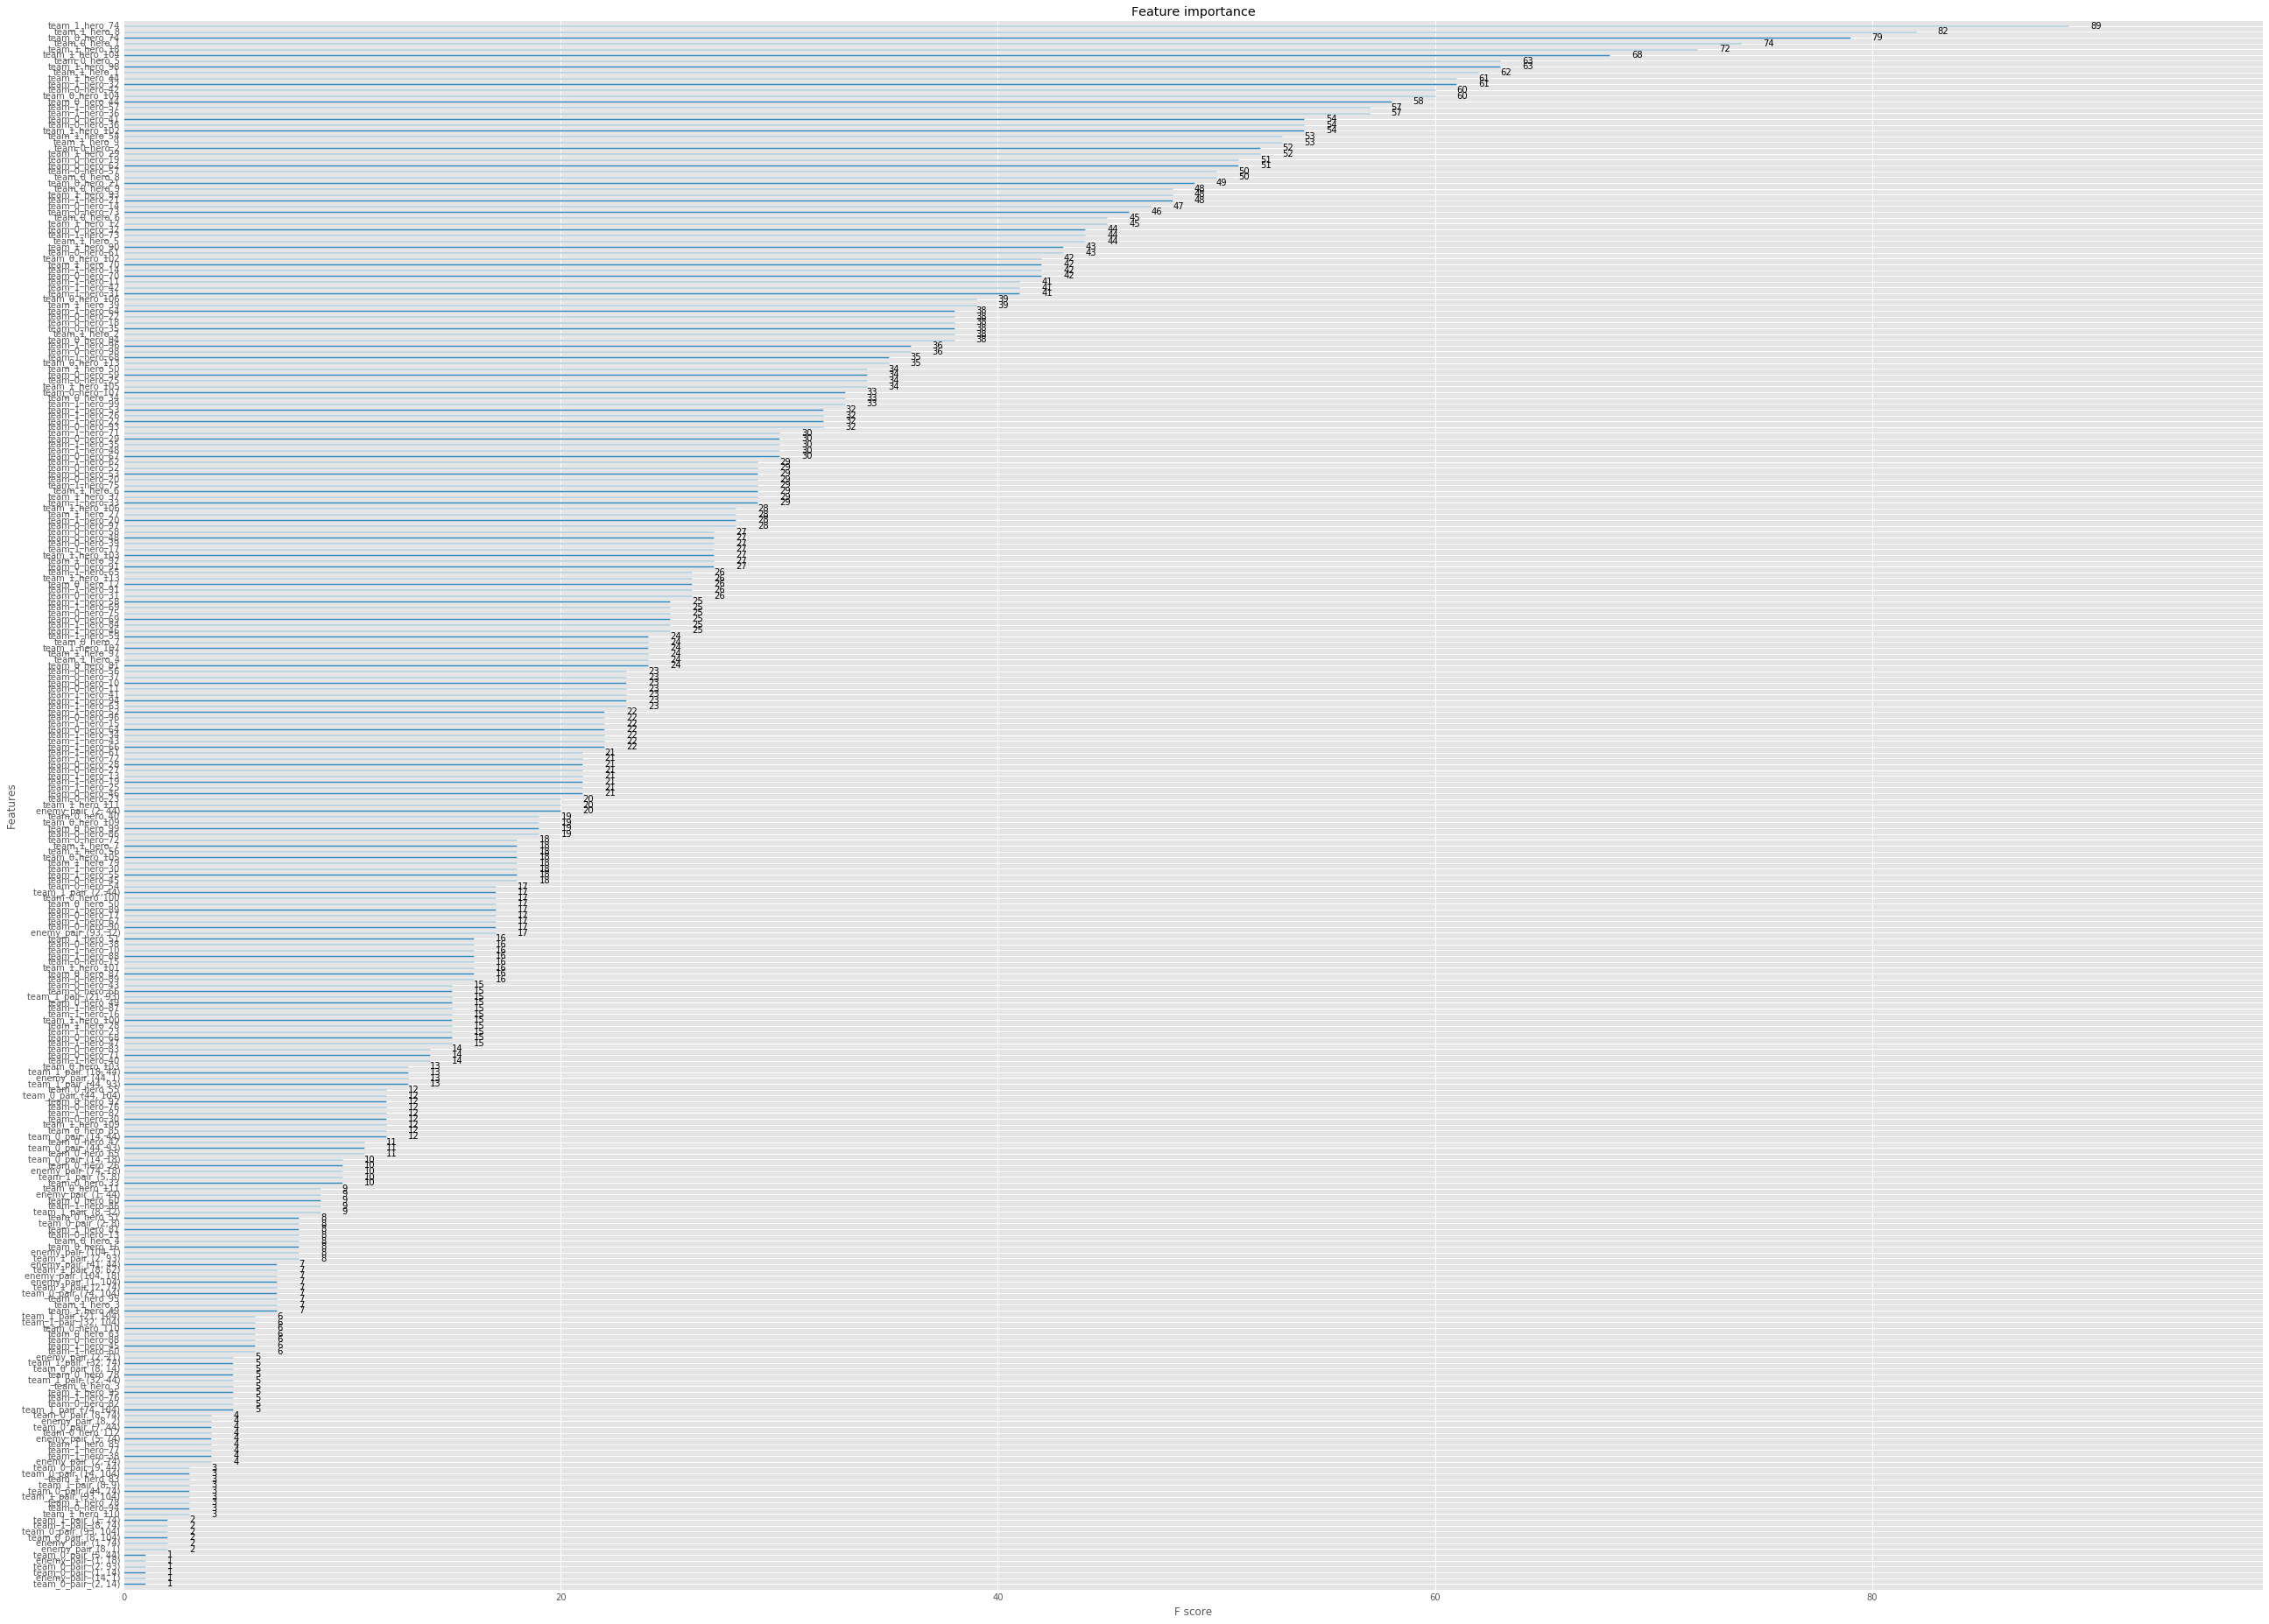

In [218]:
xgb.plot_importance(xgb_team_comp)

In [112]:
xgb_team_comp_cv = get_xgb_model_team_comp()
cv_scores = cross_val_score(xgb_team_comp_cv, t_team_comp_train_X, t_team_comp_train_Y, cv=3)
print cv_scores
np.mean(cv_scores)

[ 0.66556689  0.65896821  0.64285714]


0.65579741194618224

## Get results for test data

In [13]:
t_sub_test_details = pd.read_csv("transformed_data/one_hot_heroes_details_pairs_enemies_test")
t_sub_test_details_X = t_sub_test_details[t_sub_test_details.columns[11:]]
t_sub_test_details_X.index = t_sub_test_details["match_id"]
not_null = np.array((t_sub_test_details.isnull().any(axis=1)) == False)
has_null = np.array(t_sub_test_details.isnull().any(axis=1))
t_sub_test_details_X = t_sub_test_details_X[not_null]

t_sub_test_team_comp = pd.read_csv("transformed_data/pairs_enemies_test")
t_sub_test_team_comp_X = t_sub_test_team_comp[t_sub_test_team_comp.columns[11:]]
t_sub_test_team_comp_X.index = t_sub_test_team_comp["match_id"]
t_sub_test_team_comp_X = t_sub_test_team_comp_X[has_null]

In [14]:
results_details = xgb_model_submission.predict(t_sub_test_details_X)
results_team_comp = xgb_team_comp.predict(t_sub_test_team_comp_X)

results = np.append(results_details, results_team_comp)
result_match_ids = np.append(t_sub_test_details_X.index, t_sub_test_team_comp_X.index)

In [15]:
df_cols = {"match_id":result_match_ids, "first_5_won":results}

results_df = pd.DataFrame(data=df_cols)
results_df = results_df[["match_id", "first_5_won"]]
# results.index = result_match_ids
# results.columns = ["first_5_won"]
SUBMISSION_NAME = "submissions/sub10-25.csv"
results_df.to_csv(SUBMISSION_NAME, index=False)

lines = []
with open(SUBMISSION_NAME, 'r') as f:
    for line in f:
#         lines.append(line.replace(',', ', '))
        lines.append(line)
with open(SUBMISSION_NAME, 'w') as f:
    f.write(lines[0])
    for line in lines[1:]:
        f.write(line.upper())

## Unused Code

In [ ]:
# t_pairs_test = overview_test.join(is_pair_team_0_test)
# t_pairs_test = t_pairs_test.join(is_pair_team_1_test)

# pairing_importances_0_test = []
# for pair in is_pair_team_0_test.columns:
#     games = t_pairs_test[t_pairs_test[pair] == 1]
#     if len(games) == 0:
#         continue
#     win_percent = len(games[games["first_5_won"] == True])*1.0 / len(games)
#     pairing_importances_0_test.append((pair, len(games), win_percent, 1 - win_percent))
    
# pairing_importances_0_test.sort(key=lambda t:t[2])
    
# pairing_importances_1_test = []
# for pair in is_pair_team_1_test.columns:
#     games = t_pairs_test[t_pairs_test[pair] == 1]
#     if len(games) == 0:
#         continue
#     win_percent = len(games[games["first_5_won"] == True])*1.0 / len(games)
#     pairing_importances_1_test.append((pair, len(games), win_percent, 1 - win_percent))
    
# pairing_importances_1_test.sort(key=lambda t:t[2])

## Random

In [80]:
test_match_ids = overview_test["match_id"]
random_results = ["TRUE" if flip else "FALSE" for flip in np.random.binomial(1, 0.5, size=len(test_match_ids))]
df_random_results = pd.DataFrame({"match_id":test_match_ids, "first_5_won":random_results})
df_random_results = df_random_results[["match_id", "first_5_won"]]
df_random_results.to_csv("submissions/rand_binomial.csv", index=False)